# Crimes in Chicago

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from collections import Counter
import itertools

In [2]:
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [4]:
df = pd.read_csv('/Users/shutinggu/Desktop/1007-project/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv')

### Feature Selection

In [5]:
dataframe = df.copy()

In [6]:
#Check the raw data structure



# nunique = dict(zip(df.columns, [df[col].nunique() for col in df.columns]))
# summary = pd.DataFrame({'number_nan':df.isna().sum(), # [df.isna().sum()][0], here [0] coerces list into series with 12 separate values
#                         'number_distinct':[df[col].nunique() for col in df.columns],
#                        'distinct vals': [df[col].unique() for col in df.columns],
#                        'data type': [type(df[col][0]) for col in df.columns]})
# summary

In [7]:
dataframe = dataframe[['Date','Primary Type','Location Description', 'Domestic','Community Area']]

In [8]:
dataframe  = dataframe.dropna()

In [9]:
dataframe.head()

,Date,Primary Type,Location Description,Domestic,Community Area
0,05/03/2016 11:40:00 PM,BATTERY,APARTMENT,True,29.0
1,05/03/2016 09:40:00 PM,BATTERY,RESIDENCE,True,42.0
2,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,STREET,False,25.0
3,05/03/2016 10:10:00 PM,BATTERY,SIDEWALK,False,25.0
4,05/03/2016 10:00:00 PM,THEFT,RESIDENCE,True,25.0


In [10]:
dataframe.Date = pd.to_datetime(dataframe.Date, format='%m/%d/%Y %I:%M:%S %p')

In [11]:
dataframe.head()

,Date,Primary Type,Location Description,Domestic,Community Area
0,2016-05-03 23:40:00,BATTERY,APARTMENT,True,29.0
1,2016-05-03 21:40:00,BATTERY,RESIDENCE,True,42.0
2,2016-05-03 23:31:00,PUBLIC PEACE VIOLATION,STREET,False,25.0
3,2016-05-03 22:10:00,BATTERY,SIDEWALK,False,25.0
4,2016-05-03 22:00:00,THEFT,RESIDENCE,True,25.0


In [12]:
dataframe['Year']=dataframe['Date'].dt.year
dataframe['Month']=dataframe['Date'].dt.month
dataframe['Day']=dataframe['Date'].dt.day
dataframe['Time']=dataframe['Date'].dt.hour*3600+dataframe['Date'].dt.minute*60+dataframe['Date'].dt.second
dataframe['Day of Week']=dataframe['Date'].dt.dayofweek

In [13]:
# drop date
dataframe = dataframe.drop('Date',1)

In [14]:
dataframe.shape[0]/df.shape[0]
# We just drop NA values because it takes up only about 1%
# dataframe is our whole data including train and test
df_copy = dataframe.copy()

In [15]:
train, test = train_test_split(dataframe, test_size=0.2, random_state =32)
train = train.reset_index(drop=True)
test = test.reset_index(drop = True)

In [16]:
train.head()

,Primary Type,Location Description,Domestic,Community Area,Year,Month,Day,Time,Day of Week
0,THEFT,SMALL RETAIL STORE,False,3.0,2016,9,30,60000,4
1,CRIMINAL DAMAGE,STREET,False,24.0,2012,11,26,43200,0
2,NARCOTICS,SIDEWALK,False,29.0,2012,3,11,67140,6
3,OTHER OFFENSE,VEHICLE NON-COMMERCIAL,False,71.0,2016,1,14,81060,3
4,BATTERY,APARTMENT,True,61.0,2014,3,29,360,5


## Feature Engineering

In [17]:
# make a dictionary of Primary Type
pt_id=dict(zip(train['Primary Type'].unique(), range(1,train['Primary Type'].nunique()+1)))

def id_pt(pt):
    if pt in pt_id:
        return pt_id[pt]
    else:
         return 0

# make a dictionary of Location Description according to the count of each location in a descending order.
# Pick N top location descriptions that crimes 
def loc_des(N, df=train):
    loc_des_count = dict(Counter(df['Location Description']).most_common(N))
    loc_des_id = dict()
    for i, key in enumerate(loc_des_count.keys()):
        loc_des_id[key] = i+1
    value_dropped = set(dict(Counter(df['Location Description'])))-set(loc_des_count)
    return loc_des_id, value_dropped

# We pick 25 here
loc_des_id, value_dropped = loc_des(25, train)

def id_loc_des(des):
    if des in loc_des_id:
        return loc_des_id[des]
    else:
         return 0
        

## Let key and value reverse
name = dict()
for key, value in loc_des_id.items():
    name[value]=key

### Change the name of column for N columns. Will use below
def change_name(N):
    gname=dict()
    for i in range(1,N+1):
        gname['Location_Description_{}'.format(i)] = 'Location_Description_{}'.format(name[i])
    return gname

gname = change_name(25)

In [18]:
def transform(df):
    '''
    Input the dataframe after feature selection and the number of location descriptions we want to use
    Output the transformed dataframe for modeling
    '''
    
    df_new = df.copy()
    
    # Target Variable
    ## Change the Primary Type from str to int
    df_new['Primary Type'] = df_new['Primary Type'].apply(id_pt)
        
        
    # Features
    ## Change the Location Description from str to int. Drop the initial Location Description
    df_new['Location Description'] = df_new['Location Description'].apply(id_loc_des)
    loc = pd.get_dummies(df_new['Location Description'], drop_first=True, prefix = 'Location_Description')
    loc = loc.rename(columns = gname)
    df_new = pd.merge(df_new, loc, left_index=True, right_index = True)
    df_new = df_new.drop('Location Description',1)
    
    
    # Change binary variable Domestic into one column 
    domestic = pd.get_dummies(df_new['Domestic'], drop_first=True, prefix = 'Domestic')
    df_new = pd.merge(df_new, domestic, left_index=True, right_index = True)
    df_new = df_new.drop('Domestic',1)
    
    return df_new

In [19]:
train_df= transform(train)

In [20]:
test_df = transform(test)

In [21]:
#check if columns of train set and test set are the same
train_df.columns==test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [22]:
train_df.head()

,Primary Type,Community Area,Year,Month,Day,Time,Day of Week,Location_Description_STREET,Location_Description_RESIDENCE,Location_Description_APARTMENT,...,Location_Description_GAS STATION,Location_Description_PARK PROPERTY,Location_Description_BAR OR TAVERN,Location_Description_COMMERCIAL / BUSINESS OFFICE,Location_Description_CTA PLATFORM,Location_Description_CTA TRAIN,Location_Description_CONVENIENCE STORE,Location_Description_VACANT LOT/LAND,Location_Description_HOTEL/MOTEL,Domestic_True
0,1,3.0,2016,9,30,60000,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,24.0,2012,11,26,43200,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,29.0,2012,3,11,67140,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,71.0,2016,1,14,81060,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,61.0,2014,3,29,360,5,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [23]:
train_df.describe()

,Primary Type,Community Area,Year,Month,Day,Time,Day of Week,Location_Description_STREET,Location_Description_RESIDENCE,Location_Description_APARTMENT,...,Location_Description_GAS STATION,Location_Description_PARK PROPERTY,Location_Description_BAR OR TAVERN,Location_Description_COMMERCIAL / BUSINESS OFFICE,Location_Description_CTA PLATFORM,Location_Description_CTA TRAIN,Location_Description_CONVENIENCE STORE,Location_Description_VACANT LOT/LAND,Location_Description_HOTEL/MOTEL,Domestic_True
count,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,...,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06,1.164012e+06
mean,5.395590e+00,3.746792e+01,2.013897e+03,6.511531e+00,1.561324e+01,4.867332e+04,3.003987e+00,2.267588e-01,1.607020e-01,1.270898e-01,...,1.055659e-02,8.465548e-03,6.847868e-03,5.287746e-03,4.941530e-03,4.925207e-03,4.643423e-03,4.629677e-03,4.463872e-03,1.510998e-01
std,4.529118e+00,2.143972e+01,1.449352e+00,3.357503e+00,8.837499e+00,2.383418e+04,1.988833e+00,4.187355e-01,3.672560e-01,3.330736e-01,...,1.022016e-01,9.161818e-02,8.246806e-02,7.252441e-02,7.012215e-02,7.000681e-02,6.798430e-02,6.788407e-02,6.666295e-02,3.581463e-01
min,1.000000e+00,0.000000e+00,2.012000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2.300000e+01,2.013000e+03,4.000000e+00,8.000000e+00,3.240000e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.200000e+01,2.014000e+03,7.000000e+00,1.600000e+01,5.160000e+04,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.000000e+00,5.700000e+01,2.015000e+03,9.000000e+00,2.300000e+01,6.840000e+04,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.300000e+01,7.700000e+01,2.017000e+03,1.200000e+01,3.100000e+01,8.634000e+04,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [24]:
nunique = dict(zip(train_df.columns, [train_df[col].nunique() for col in train_df.columns]))
summary = pd.DataFrame({'number_nan':train_df.isna().sum(), # [train_df.isna().sum()][0], here [0] coerces list into series with 12 separate values
                        'number_distinct':[train_df[col].nunique() for col in train_df.columns],
                       'distinct vals': [train_df[col].unique() for col in train_df.columns],
                       'data type': [type(train_df[col][0]) for col in train_df.columns]})
summary

,number_nan,number_distinct,distinct vals,data type
Primary Type,0,33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<class 'numpy.int64'>
Community Area,0,78,"[3.0, 24.0, 29.0, 71.0, 61.0, 56.0, 6.0, 23.0,...",<class 'numpy.float64'>
Year,0,6,"[2016, 2012, 2014, 2013, 2015, 2017]",<class 'numpy.int64'>
Month,0,12,"[9, 11, 3, 1, 2, 6, 8, 12, 4, 7, 10, 5]",<class 'numpy.int64'>
Day,0,31,"[30, 26, 11, 14, 29, 3, 18, 17, 13, 24, 23, 6,...",<class 'numpy.int64'>
Time,0,3943,"[60000, 43200, 67140, 81060, 360, 84600, 7200,...",<class 'numpy.int64'>
Day of Week,0,7,"[4, 0, 6, 3, 5, 1, 2]",<class 'numpy.int64'>
Location_Description_STREET,0,2,"[0, 1]",<class 'numpy.uint8'>
Location_Description_RESIDENCE,0,2,"[0, 1]",<class 'numpy.uint8'>
Location_Description_APARTMENT,0,2,"[0, 1]",<class 'numpy.uint8'>


### train_eval

In [25]:
def train_model(model, X_train,  y_train,  param_grid={}, splits=4):

    '''
    Modeling and evaluation function

    args:
        - model: classifier object, e.g. DecisionTreeClassifier()
        - param_grid: a dictionary with possible parameters choices
        - splits: number of k-folds splits
    ''' 
    
    # create cross-validation method
    kfolds = KFold(n_splits = splits)

    ## perform cross-validation
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, cv=kfolds,
                           scoring='accuracy', return_train_score=True)
                            # Try different scoring functions provided in:
                            # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # search the grid
    gsearch.fit(X_train,y_train)

    # extract best model from the grid
    best_model = gsearch.best_estimator_  
    best_score = gsearch.best_score_
    
    # print stats on model performance         
    print('----------------------')
    print(best_model)
    print('----------------------')
    print('accuracy=',best_score)
    
    return best_model, best_score, gsearch

### Prepare data

In [26]:
X_train = train_df.drop('Primary Type',1)
y_train = train_df['Primary Type']

X_test = test_df.drop('Primary Type',1)
y_test = test_df['Primary Type']

In [27]:
Counter(y_train)

Counter({1: 263388,
         2: 123994,
         3: 108212,
         4: 70446,
         5: 210944,
         6: 73191,
         7: 48978,
         8: 3955,
         9: 13850,
         10: 66633,
         11: 29553,
         12: 59290,
         13: 6105,
         14: 45850,
         15: 1759,
         16: 10420,
         17: 9053,
         18: 2086,
         19: 537,
         20: 1770,
         21: 5462,
         22: 4957,
         23: 74,
         24: 1601,
         25: 26,
         26: 657,
         27: 895,
         28: 143,
         29: 36,
         30: 21,
         31: 74,
         32: 48,
         33: 4})

In [28]:
## Resample our train data so that we have a balanced calss size for class size less than 30000 and greater than 2000
num_desired = {8:30000, 9:35000, 11:40000, 13:30000, 15:30000, 15:30000, 16:35000, 17:30000, 18:30000, 20:30000,21:30000,22:20000}
smote = SMOTE(ratio=num_desired, random_state=100)
smote_tomek = SMOTETomek(smote=smote, random_state=200)
X_train_new, y_train_new = smote_tomek.fit_sample(X_train, y_train)

In [32]:
Counter(y_train_new)

Counter({1: 175436,
         3: 67739,
         4: 39968,
         2: 72626,
         5: 137418,
         8: 26671,
         6: 40893,
         9: 27689,
         10: 38124,
         7: 27360,
         12: 34479,
         13: 26247,
         11: 26713,
         15: 27748,
         14: 24959,
         16: 28284,
         17: 26112,
         18: 27525,
         20: 27634,
         21: 26843,
         22: 15853,
         24: 822,
         26: 347,
         27: 460,
         19: 276,
         29: 22,
         30: 13,
         28: 72,
         25: 15,
         32: 25,
         23: 38,
         31: 39,
         33: 2})

In [33]:
## Note SMOTE method returns numpy array, so we need add the column names
X_train_new = pd.DataFrame(X_train_new, columns=X_train.columns)
y_train_new = pd.Series(y_train_new)

W'll use `X_train_new` and `y_train_new` for modeling. Use `X_train` and `y_train` for Graphing

## Model Architechture

In [34]:
# places to store optimal models and scores
opt_models = dict()
model_lst = []
score_lst = []

# no. k-fold splits
splits=4

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


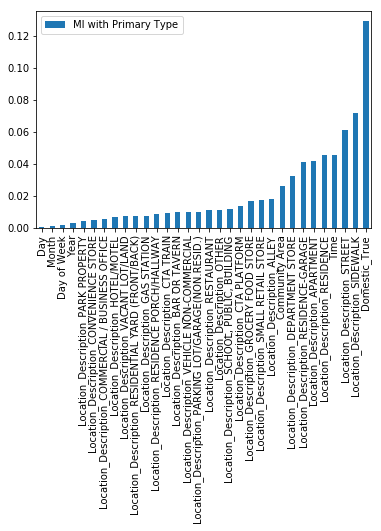

In [35]:
# Take a look of mutual information of y with all x.
ml = []
for col in X_train.columns:
    ml.append(normalized_mutual_info_score(X_train[col], y_train))
df_ml = pd.DataFrame(ml, index =X_train.columns,columns = ['MI with Primary Type'])
df_ml.sort_values(by= ['MI with Primary Type']).plot.bar()

#### Baseline Model

In [36]:
# No need for parameter tuning
model = 'Logistc Regression'
opt_models[model] = LogisticRegression(multi_class = 'multinomial',solver='lbfgs',verbose=2)
X_tr, X_te, y_tr, y_te = train_test_split(X_train_new, y_train_new, test_size = 0.2)
opt_models[model].fit(X_tr,y_tr)
pred=opt_models[model].predict(X_te)
s = accuracy_score(pred, y_te)
s
score_lst.append(s)
model_lst.append(opt_models[model])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


In [38]:
score_lst

[0.18458967478689026]

#### Decision Tree

In [39]:
model = 'Decision Tree'
opt_models[model] = DecisionTreeClassifier()

min_samples_split = [10,100,500,1000,2000]
min_samples_leaf = [5,10,250,500,1000]
param_grid = {'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'max_depth':[5],"criterion": ["entropy"]}

opt_models[model], cv_score, grid = train_model(opt_models[model], X_train_new, y_train_new, param_grid)
print(score_lst.append(cv_score))
print(model_lst.append(opt_models[model]))

----------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
----------------------
accuracy= 0.2714992429769772
None
None


#### Plot the confusion matrix to see tp, tn, fp, fn

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()


# Compute confusion matrix
confusion =confusion_matrix(y_te, pred)   # Now it's just logistic regression. Will implement into other models later
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(30,20))
plot_confusion_matrix(confusion, classes=range(0,32),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(confusion, classes=range(0,32), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [138]:
#Counter(df.Arrest)

Counter({True: 371057, False: 1047308})

In [51]:
#Counter(df.Domestic)

Counter({True: 215134, False: 1203231})

In [28]:
#df.groupby(['Primary Type','Arrest']).count()['ID']